In [1]:
import os
import glob
import traceback
import numpy as np

from utils.main_function_helpers import *

os.environ['CUDA_VISIBLE_DEVICES'] = '2'


import torch
import argparse
import os
import yaml
import pathlib
import pickle
import logging
import sys
import time
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torchvision
import glob
from torch.serialization import default_restore_location
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import numpy as np
from tensorboard.backend.event_processing import event_accumulator

import utils
import models 

from utils.data_helpers.load_datasets_helpers import *
from utils.meters import *
from utils.progress_bar import *
from utils.noise_model import get_noise
from utils.metrics import ssim,psnr
from utils.util_calculate_psnr_ssim import calculate_psnr,calculate_ssim
from utils.test_metrics import *

import copy


In [2]:
# Configure the path to ImageNet dataset and the training set size

#path_to_ImageNet_train = '../../../../../media/hdd1/ImageNet/ILSVRC/Data/CLS-LOC/'
path_to_ImageNet_train = '../../'
train_size = 1000

In [3]:
# Hyperparameters during training 
lr = 6.4e-4
fix_noise = True
noise_std = 25
batch_size = 1
patch_size = 128
val_crop = False
seed = 42

In [4]:
USE_CUDA = True
device = torch.device('cuda') if (torch.cuda.is_available() and USE_CUDA) else torch.device('cpu')

model = models.unet_fastMRI(
            in_chans=3,
            chans = 128,
            num_pool_layers = 2,
            drop_prob = 0.0,
            residual_connection = True,
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

trainset = ImagenetSubdataset(train_size,path_to_ImageNet_train,mode='train',patch_size=patch_size,val_crop=val_crop)
train_loader = DataLoader(trainset, batch_size= batch_size, shuffle=True, num_workers=8, pin_memory=True,generator=torch.Generator().manual_seed(seed))




In [5]:
# Train the model for one epoch

train_bar3 = ProgressBar(train_loader)
true_grad = []

param = list(model.parameters())

        
for inputs, noise_seed in train_bar3:
    
    model.train() #Sets the module in training mode.
    inputs = inputs.to(device)
    noise = get_noise(inputs,noise_seed, fix_noise = fix_noise, noise_std = noise_std/255.)
                    

    model.zero_grad()    
    noisy_inputs = noise + inputs
    outputs = model(noisy_inputs)

    loss_sup = F.mse_loss(outputs, inputs, reduction="sum") / torch.prod(torch.tensor(inputs.size())) #(inputs.size(0) * 2) 
    loss_sup.backward()
    optimizer.step()


In [6]:
#Calculate the true gradient

train_bar = ProgressBar(train_loader)
true_grad = []

param = list(model.parameters())
k=0
        
for inputs, noise_seed in train_bar:
    
    k=k+1
    
    model.train() #Sets the module in training mode.

    inputs = inputs.to(device)
    
    noise = get_noise(inputs,noise_seed, fix_noise = fix_noise, noise_std = noise_std/255.)
                    

    noisy_inputs = noise + inputs
    outputs = model(noisy_inputs)

    loss_sup = F.mse_loss(outputs, inputs, reduction="sum") / torch.prod(torch.tensor(inputs.size())) #(inputs.size(0) * 2)
    
    #model.zero_grad()    
    loss_sup.backward()

    #for p in param:
    #    if k == 1:
    #        p.grad_true = p.grad
    #    else:
    #        p.grad_true = p.grad_true + p.grad
    #    p.grad = None
    
#for p in param:
#    p.grad_true = p.grad_true / train_size
#    true_grad.append(p.grad_true)

length = torch.zeros(1).to(device)
for p in param:
    p.grad = p.grad / train_size
    true_grad.append(p.grad)
    length += torch.sum(torch.square(p.grad))


In [7]:
train_bar2 = ProgressBar(train_loader)
normalized_diff_tn25 = []
normalized_diff_tn50 = []
normalized_diff_tn0 = []
#length = 0
for inputs, noise_seed in train_bar2:
    
    model.train() #Sets the module in training mode.

    inputs = inputs.to(device)
    
    noise = get_noise(inputs,noise_seed, fix_noise = fix_noise, noise_std = noise_std/255.)
    noise_target_tn25 = get_noise(inputs,torch.mul(noise_seed,10),fix_noise = fix_noise, noise_std = 25/255.)
    noise_target_tn50 = get_noise(inputs,torch.mul(noise_seed,100),fix_noise = fix_noise, noise_std = 50/255.)
                

    noisy_targets_tn25 = noise_target_tn25 + inputs 
    noisy_targets_tn50 = noise_target_tn50 + inputs 

    noisy_inputs = noise + inputs
    outputs = model(noisy_inputs)
    # In loss function, I changed outputs to noisy_targets for self-supervision
    loss_tn50 = F.mse_loss(outputs, noisy_targets_tn50, reduction="sum") / torch.prod(torch.tensor(inputs.size())) #(inputs.size(0) * 2)
    loss_tn25 = F.mse_loss(outputs, noisy_targets_tn25, reduction="sum") / torch.prod(torch.tensor(inputs.size())) #(inputs.size(0) * 2)
    loss_sup = F.mse_loss(outputs, inputs, reduction="sum") / torch.prod(torch.tensor(inputs.size())) #(inputs.size(0) * 2)

    param = list(model.parameters())
    
    
    model.zero_grad()
    
    loss_tn50.backward(retain_graph=True)
    
    
    for p in param:
        p.grad_tn50 = p.grad
        p.grad = None
    
    
    loss_tn25.backward(retain_graph=True)
    
    
    for p in param:
        p.grad_tn25 = p.grad
        p.grad = None
    
    
    loss_sup.backward()

    for p in param:
        p.grad_sup = p.grad
        p.grad = None
    
    
    diff_tn25 = torch.zeros(1).to(device)
    diff_tn50 = torch.zeros(1).to(device)
    diff_tn0 = torch.zeros(1).to(device)
    #length = torch.zeros(1).to(device)
    for idx,p in enumerate(param):
        diff_tn0 += torch.sum(torch.square(torch.sub(p.grad_sup,true_grad[idx])))
        diff_tn25 += torch.sum(torch.square(torch.sub(p.grad_tn25,true_grad[idx])))
        diff_tn50 += torch.sum(torch.square(torch.sub(p.grad_tn50,true_grad[idx])))
        #length += torch.sum(torch.square(true_grad[idx]))
        

        
    normalized_diff_tn25.append(torch.div(diff_tn25,length).item())
    normalized_diff_tn50.append(torch.div(diff_tn50,length).item())
    normalized_diff_tn0.append(torch.div(diff_tn0,length).item())


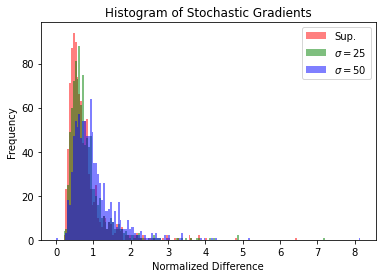

In [13]:
# Overlay the histograms
# Create a histogram of the data with three different colors
#plt.hist([normalized_diff_tn0, normalized_diff_tn25, normalized_diff_tn50], bins=int(np.sqrt(train_size)), alpha=0.5, label=['Sup.', '$\sigma = 25$', '$\sigma = 50$'], color=['red', 'green', 'blue'])
binwidth = 0.05 #1/int(np.sqrt(train_size))
data = []
for c in normalized_diff_tn0:
    data.append(c)
for c in normalized_diff_tn25:
    data.append(c)
for c in normalized_diff_tn50:
    data.append(c)
plt.hist(normalized_diff_tn0,bins=np.arange(min(data), max(data) + binwidth, binwidth), alpha=0.5, label='Sup.', color='red')
plt.hist(normalized_diff_tn25,bins=np.arange(min(data), max(data) + binwidth, binwidth), alpha=0.5, label='$\sigma = 25$', color='green')
plt.hist(normalized_diff_tn50,bins=np.arange(min(data), max(data) + binwidth, binwidth), alpha=0.5, label='$\sigma = 50$', color='blue')
# Add a legend to the plot
plt.legend(loc='upper right')

# Add labels and a title
plt.xlabel('Normalized Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Stochastic Gradients')

# Show the plot
plt.show()

In [12]:
# Mean of the plots
print('Mean of supervised gradients: ' + str(np.mean(normalized_diff_tn0)))
print('Mean of gradients when target noise = 25 : ' + str(np.mean(normalized_diff_tn25)))
print('Mean of gradients when target noise = 50 : ' + str(np.mean(normalized_diff_tn50)))


Mean of supervised gradients: 0.7503698582500219
Mean of gradients when target noise = 25 : 0.8228823760896922
Mean of gradients when target noise = 50 : 0.9972730349898339


In [ ]:
os._exit(00)

: 

: 